In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import pennylane as qml
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)
        a=(a+1)/2
        b=(b+1)/2
        

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

In [3]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])
path2img = 'data/facades/train'
train_ds = FacadeDataset(path2img, transform=transform)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [4]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x
    
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x):
        x = self.up(x)
        return x
    
# n_qubits = 8
# dev = qml.device("lightning.qubit", wires=n_qubits)
# @qml.qnode(dev, interface="torch")
# def qc(inputs, weights):
#     for i in range(n_qubits):
#         qml.RY(2*np.pi*i,wires=i)
#     q_depth=3
#     k=0


#     # Repeated layer
#     for i in range(q_depth):
#         # Parameterised layer
#         for y in range(n_qubits):
#             qml.RY(weights[k], wires=y)
#             k+=1

#         # Control Z gates
#         for y in range(n_qubits - 1):
#             qml.CZ(wires=[y, y + 1])

#     return qml.probs(wires=list(range(n_qubits)))

# weight_shapes = {"weights": n_qubits*3}
# qlayer = qml.qnn.TorchLayer(qc, weight_shapes)


In [5]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 8, normalize=False)
        self.down2 = UNetDown(8,16)                 
        self.down3 = UNetDown(16,64)               
        self.down4 = UNetDown(64,256,dropout=0.5) 
        self.down5 = UNetDown(256,256,dropout=0.5)      
        self.down6 = UNetDown(256,256,dropout=0.5)             
        self.down7 = UNetDown(256,256,dropout=0.5)              
        self.down8 = UNetDown(256,256,normalize=False,dropout=0.5)
        # self.qlayer = qlayer
        self.up1 = UNetUp(256,256,dropout=0.5)
        self.up2 = UNetUp(256,256,dropout=0.5)
        self.up3 = UNetUp(256,256,dropout=0.5)
        self.up4 = UNetUp(256,256,dropout=0.5)
        self.up5 = UNetUp(256,64)
        self.up6 = UNetUp(64,16)
        self.up7 = UNetUp(16,8)
        self.up8 = nn.Sequential(
            UNetUp(8,3),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        
        d2 = self.down2(d1)
       
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        # d8=d8.reshape(8)
        # amp=d8.norm()
        # d8=d8/amp
        # c0=self.qlayer(d8)*amp
        # c0=c0.reshape(1,256,1,1)
        u1 = self.up1(d8)
        u2 = self.up2(u1)
        u3 = self.up3(u2)
        u4 = self.up4(u3)
        u5 = self.up5(u4)
        u6 = self.up6(u5)
        u7 = self.up7(u6)
        u8 = self.up8(u7)
        return u8





In [6]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x



In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x


In [8]:
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)




In [9]:
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
dis_lr = 2e-4
gen_lr = 1e-2
beta1 = 0.5
beta2 = 0.999
model_dis=Discriminator().cuda()
model_gen=GeneratorUNet().cuda()
opt_dis = optim.Adam(model_dis.parameters(),lr=dis_lr)
opt_gen = optim.Adam(model_gen.parameters(),lr=gen_lr)

In [10]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 20
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[],
             'genl':[] }

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별
        

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())
        loss_hist['genl'].append(gen_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60) )

Epoch: 0, G_Loss: 18.493525, D_Loss: 0.190576, time: 0.20 min
Epoch: 0, G_Loss: 23.538387, D_Loss: 0.206459, time: 0.40 min
Epoch: 0, G_Loss: 21.293474, D_Loss: 0.129130, time: 0.60 min
Epoch: 0, G_Loss: 24.647659, D_Loss: 0.076980, time: 0.77 min
Epoch: 1, G_Loss: 23.180115, D_Loss: 0.016583, time: 0.95 min
Epoch: 1, G_Loss: 22.355793, D_Loss: 0.014998, time: 1.13 min
Epoch: 1, G_Loss: 24.464359, D_Loss: 0.097340, time: 1.32 min
Epoch: 1, G_Loss: 31.902697, D_Loss: 0.004508, time: 1.52 min
Epoch: 2, G_Loss: 28.243006, D_Loss: 0.020671, time: 1.71 min
Epoch: 2, G_Loss: 28.188858, D_Loss: 0.007339, time: 1.90 min
Epoch: 2, G_Loss: 23.079842, D_Loss: 0.099104, time: 2.10 min
Epoch: 2, G_Loss: 29.140896, D_Loss: 0.083382, time: 2.26 min
Epoch: 3, G_Loss: 27.151878, D_Loss: 0.006115, time: 2.43 min
Epoch: 3, G_Loss: 29.376879, D_Loss: 0.004825, time: 2.61 min
Epoch: 3, G_Loss: 27.132915, D_Loss: 0.015933, time: 2.80 min
Epoch: 3, G_Loss: 20.635756, D_Loss: 0.082949, time: 2.98 min
Epoch: 4

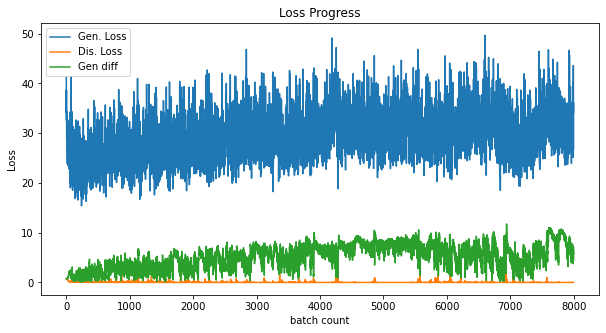

In [12]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.plot(loss_hist['genl'], label='Gen diff')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [14]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [15]:
# evaluation model
model_gen.eval()
fake_imgs=[]
real_imgs=[]
# 가짜 이미지 생성
with torch.no_grad():
    j=0
    for a,b in train_dl:
        fake_imgs.append(model_gen(a.to(device)).detach().cpu())
        real_imgs.append(b)
        j+=1
        if j>4:
            break

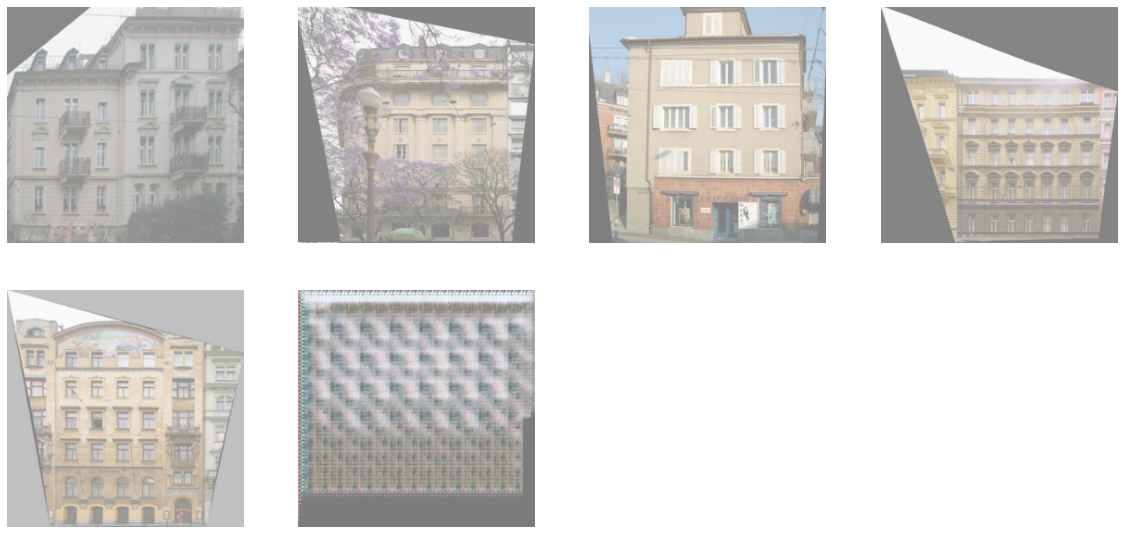

In [17]:
# 가짜 이미지 시각화
plt.figure(figsize=(20,20))

for ii in range(0,5):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii][0]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii][0]+0.5))
    plt.axis('off')

